In [1]:
from pathlib import Path
import json

import cv2
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
def read_ann(json_path):
    with open(json_path, "r") as f:
        ann = json.load(f)
    
    return ann

def prepare_mask(ann):
    h, w = ann['imageHeight'], ann['imageWidth']
    mask = np.zeros((h, w), dtype=np.uint8)
    for shape in ann['shapes']:
        if shape['label'].lower().find('leaf') >= 0:
            cv2.drawContours(mask, np.array(shape['points']).astype(np.int32)[np.newaxis, ...], -1, (1,), thickness=-1)
    
    return mask

In [3]:
img_path = Path("/workdir/strawberry_hack/strawberry_desease/train/angular_leafspot1.jpg")
json_path = Path("/workdir/strawberry_hack/strawberry_desease/train/angular_leafspot1.json")
ann = read_ann(json_path)
mask = prepare_mask(ann)

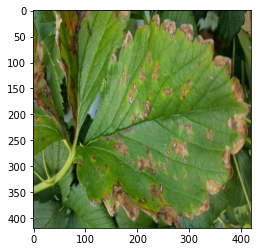

In [4]:
imshow(cv2.imread(str(img_path))[..., ::-1]);

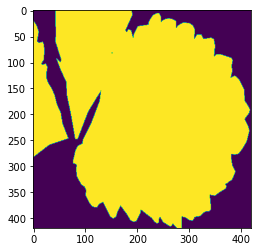

In [5]:
imshow(mask);

In [7]:
data_dirs = [
    Path("/workdir/strawberry_hack/strawberry_desease/train/"),
    Path("/workdir/strawberry_hack/strawberry_desease/val/")
]
out_dir = Path("/workdir/strawberry_hack/strawberry_desease/masks_all")
out_dir.mkdir(parents=True, exist_ok=True)

labels = {'image_path': [], 'mask_path': []}

for data_dir in data_dirs:
    for img_path in tqdm(list(data_dir.iterdir())):
        if img_path.suffix == ".json":
            continue
        
        json_path = data_dir / (img_path.stem + ".json")
        ann = read_ann(json_path)
        mask = prepare_mask(ann)
        
        mask_path = out_dir / (img_path.stem + ".png")
        cv2.imwrite(str(mask_path), mask)
        
        labels["image_path"].append(img_path.relative_to("/workdir/strawberry_hack/"))
        labels["mask_path"].append(mask_path.relative_to("/workdir/strawberry_hack/"))

100%|██████████| 614/614 [00:00<00:00, 1941.79it/s]


In [8]:
labels = pd.DataFrame(labels)
labels.shape

(1757, 2)

In [30]:
labels.head()

,image_path,mask_path
0,strawberry_desease/train/leaf_spot241.jpg,strawberry_desease/masks_all/leaf_spot241.png
1,strawberry_desease/train/gray_mold53.jpg,strawberry_desease/masks_all/gray_mold53.png
2,strawberry_desease/train/powdery_mildew_leaf16...,strawberry_desease/masks_all/powdery_mildew_le...
3,strawberry_desease/train/powdery_mildew_leaf29...,strawberry_desease/masks_all/powdery_mildew_le...
4,strawberry_desease/train/leaf_spot45.jpg,strawberry_desease/masks_all/leaf_spot45.png


In [9]:
train = pd.read_csv("/workdir/strawberry_hack/leaves_720p_train.csv")
train.shape

(1632, 2)

In [10]:
joined_train = pd.concat([labels, train])
joined_train.shape

(3389, 2)

In [11]:
joined_train.to_csv("/workdir/strawberry_hack/leaves_joined_720p_train.csv", index=False)